# Potato Disease Classification

### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

### Set all the Constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels, 256*256 is image size, 3 is the RGB channels.

In [6]:
len(dataset)

68

this is because, its like there are 32 batches with 68 images each

In [7]:
32 * 68

2176

which is almost near to 2152(length of our true dataset, here the 68th batch is not perfect.

### Visualize some of the images from our dataset

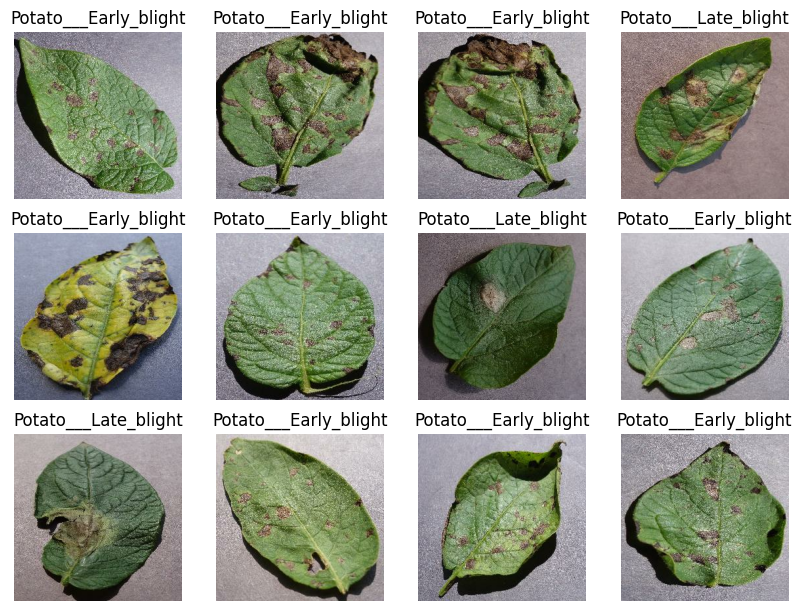

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training(80%)
2. Validation: Dataset to be tested against while training(10%)
3. Test: Dataset to be tested against after we trained a model(10%)

In [9]:
len(dataset)

68

In [10]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

dataset[54:]

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

### Cache, Shuffle, and Prefetch the Dataset

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

**We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks.**

NOtes for feature extractoin in cnn
In a convolutional neural network (CNN), feature extraction is performed using convolution, ReLU activation, and pooling operations.

Convolution: Convolution is the process of applying filters (small matrices) to the input image. Each filter is applied to different regions of the image, and the result is a feature map that highlights certain patterns or features. For example, a filter might detect edges or textures in the image.

Example: Suppose we have a 3x3 filter for edge detection:

Input Image:
|1 1 1|
|1 1 1|
|1 1 1|

Filter:
|1 0 -1|
|1 0 -1|
|1 0 -1|

Convolution Result:
|0 0 0|
|0 0 0|
|0 0 0|

ReLU Activation: ReLU (Rectified Linear Unit) is an activation function that introduces non-linearity to the network. It sets negative values to zero and keeps positive values unchanged. ReLU helps in introducing non-linearity and learning complex patterns in the data.

Example: After applying ReLU activation to the convolution result:

Convolution Result:
|0 0 0|
|0 0 0|
|0 0 0|

ReLU Activation Result:
|0 0 0|
|0 0 0|
|0 0 0|

Pooling: Pooling is a downsampling operation that reduces the spatial dimensions of the feature maps. It helps in capturing the most important features while reducing the computational complexity. Max pooling is a commonly used pooling operation, which selects the maximum value within a defined window.

Example: Suppose we have a 2x2 max pooling operation:

Input Feature Map:
|2 4 1 2|
|1 3 0 5|
|9 7 2 6|
|2 4 8 1|

Max Pooling Result:
|4 5|
|9 8|

These operations are repeated in CNNs to extract hierarchical features from the input image, leading to more abstract representations as we go deeper into the network.

# Benefits of convolution in convolutional neural networks (CNNs):

1. Local feature extraction: Convolution allows the network to focus on local regions of the input image, enabling it to extract local features such as edges, textures, and patterns.

2. Parameter sharing: Convolutional layers share their parameters across different spatial locations, which significantly reduces the number of parameters compared to fully connected layers. This parameter sharing makes CNNs more computationally efficient and able to learn from limited training data.

3. Translation invariance: Convolutional layers are translation invariant, meaning they can detect features regardless of their position in the image. This property makes CNNs robust to variations in the location of objects or patterns in the input.

4. Hierarchical feature representation: CNNs consist of multiple convolutional layers stacked together. Each layer captures increasingly complex and abstract features by learning from the features extracted in the previous layers. This hierarchical representation allows CNNs to learn high-level representations of the input data.

5. Dimensionality reduction: Convolutional layers often employ pooling operations (such as max pooling) to reduce the spatial dimensions of the feature maps. This downsampling helps in reducing the computational complexity of subsequent layers while retaining the most salient features.

Overall, convolution plays a crucial role in CNNs by enabling local feature extraction, parameter sharing, translation invariance, hierarchical feature representation, and dimensionality reduction. These benefits contribute to the effectiveness and efficiency of CNNs in various computer vision tasks.

#Benefits of ReLU (Rectified Linear Unit) activation function:

1. Non-linearity: ReLU introduces non-linearity to the neural network, allowing it to learn and model complex relationships in the data.

2. Sparse activation: ReLU produces sparse activation, meaning it activates only a subset of neurons, which helps in reducing the computational complexity and overfitting.

3. Simplicity: ReLU is a simple activation function to implement and computationally efficient, making it suitable for deep neural networks with many layers.

4. Avoiding vanishing gradient problem: ReLU helps in mitigating the vanishing gradient problem by preventing gradients from becoming too small during backpropagation, which can lead to slow learning or vanishing gradients.

5. Dense representation: ReLU allows for dense and informative representations in the network, enabling better discrimination between different classes or features in the data.

In summary, ReLU offers non-linearity, sparsity, simplicity, mitigation of the vanishing gradient problem, and dense representation, making it a popular choice as an activation function in neural networks.

#Benefits of Pooling in convolutional neural networks:

1. Dimensionality reduction: Pooling reduces the spatial dimensions of the input feature maps, leading to a smaller and more manageable representation of the data.

2. Translation invariance: Pooling creates a summary statistic (e.g., maximum or average) of the local neighborhood, making the network less sensitive to small translations in the input data.

3. Robustness to noise: Pooling can help reduce the impact of noise or small variations in the input data by summarizing the information within local regions.

4. Computational efficiency: Pooling reduces the number of parameters and computations in the network, allowing for faster training and inference.

5. Hierarchical representation: Pooling enables the network to capture higher-level features by progressively summarizing information across multiple layers.

In summary, pooling provides dimensionality reduction, translation invariance, robustness to noise, computational efficiency, and supports the hierarchical representation of features in convolutional neural networks.

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape), #convolution layer
    layers.MaxPooling2D((2, 2)),            #max pooling layer
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'), #trial and error based convolution layes and the same follows with max pooling layers
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'), #normalize the probabilities of classes
])

model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [77]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [61]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['precision']
)

In [62]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['Recall']
)

In [63]:

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['FalsePositives']
)

In [64]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['FalseNegatives']
)

In [65]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['TrueNegatives']
)

In [66]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['TruePositives']
)

In [75]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
             tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(),
             tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()]
)


In [79]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 47s 860ms/step - loss: 0.1306 - accuracy: 0.9450 - val_loss: 0.1504 - val_accuracy: 0.9427
Epoch 2/50
54/54 [==============================] - 46s 856ms/step - loss: 0.1430 - accuracy: 0.9416 - val_loss: 0.1649 - val_accuracy: 0.9375
Epoch 3/50
54/54 [==============================] - 46s 857ms/step - loss: 0.1128 - accuracy: 0.9618 - val_loss: 0.1064 - val_accuracy: 0.9427
Epoch 4/50
54/54 [==============================] - 47s 860ms/step - loss: 0.1107 - accuracy: 0.9566 - val_loss: 0.1117 - val_accuracy: 0.9688
Epoch 5/50
54/54 [==============================] - 46s 858ms/step - loss: 0.0852 - accuracy: 0.9676 - val_loss: 0.0597 - val_accuracy: 0.9740
Epoch 6/50
54/54 [==============================] - 46s 849ms/step - loss: 0.0856 - accuracy: 0.9659 - val_loss: 0.1232 - val_accuracy: 0.9479
Epoch 7/50
54/54 [==============================] - 46s 848ms/step - loss: 0.0588 - accuracy: 0.9792 - val_loss: 0.2913 - val_accuracy: 0.9010

In [80]:
# scores = model.evaluate(test_ds)
scores = model.evaluate(test_ds)


8/8 [==============================] - 1s 172ms/step - loss: 0.0687 - accuracy: 0.9805


**We can see above that we get 97.27% accuracy for our test dataset. This is considered to be a pretty good accuracy on the first build**
loss: 0.0591 - accuracy: 0.9766 on second build
 loss: 0.1136 - accuracy: 0.9688 third build
 loss: 0.1114 - accuracy: 0.9648 4th

 loss: 0.1488 - accuracy: 0.9570

 loss: 0.0428 - accuracy: 0.9883 5th

In [81]:
scores

[0.06874657422304153, 0.98046875]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [82]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [83]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [84]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [85]:
type(history.history['loss'])

list

In [86]:
len(history.history['loss'])

50

In [87]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.13063108921051025,
 0.14304359257221222,
 0.11283822357654572,
 0.11067213118076324,
 0.0851936861872673]

In [88]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# precision = history.history['precision']
# val_precision = history.history['val_precision']
                                      
# recall = history.history['recall']
# val_recall = history.history['val_recall']
                                      
# false_positives = history.history['false_positives']
# val_false_positives = history.history['val_false_positives']

# false_negatives = history.history['false_negatives']
# val_false_negatives = history.history['val_false_negatives']

# true_positives = history.history['true_positives']
# val_true_positives = history.history['val_true_positives']

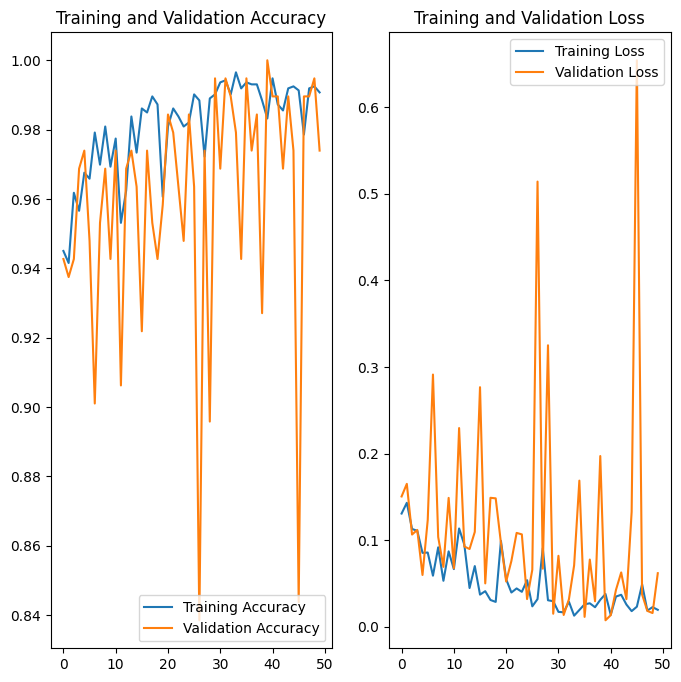

In [89]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# plt.subplot(2, 2, 3)
# plt.plot(range(EPOCHS), precision, label='Training Precision')
# plt.plot(range(EPOCHS), val_precision, label='Validation Precision')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Precision')

# plt.subplot(2, 2, 4)
# plt.plot(range(EPOCHS), recall, label='Training Recall')
# plt.plot(range(EPOCHS), val_recall, label='Validation Recall')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Recall')

# plt.tight_layout()
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 326ms/step
predicted label: Potato___Early_blight


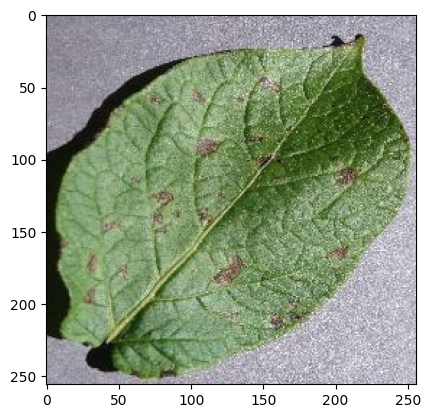

In [90]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [139]:
# def predict(model, img):
#     img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
#     img_array = tf.expand_dims(img_array, 0)

#     predictions = model.predict(img_array)
#     # predictions = np.argmax(model.predict(img_array), axis=1)

#     predicted_class = class_names[np.argmax(predictions[0])]
#     confidence = round(100 * (np.max(predictions[0])), 2)
#     return predicted_class, confidence

def predict(model, img):
    # img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_label = np.argmax(predictions[0])
    predicted_class = class_names[predicted_label]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, predicted_label, confidence


# Evaluate precision, recall, true positives, true negatives, false positives, and false negatives

In [146]:
import sklearn.metrics
true_labels = []
predicted_labels = []
true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0

for images_batch, labels_batch in test_ds:
    for i in range(len(images_batch)):
        true_label = labels_batch[i].numpy()
        true_labels.append(true_label)
        # predicted_class,  predicted_label = predict(model, images_batch[i].numpy())
        predicted_class, predicted_label, confidence = predict(model, images_batch[i].numpy())

        predicted_labels.append(predicted_label)

        if true_label == predicted_label:
            if true_label == 0:  # 'Potato___Early_blight'
                true_positives += 1
            else:  # 'Potato___Late_blight' or 'Potato___healthy'
                true_negatives += 1
        else:
            if predicted_label == 0:  # 'Potato___Early_blight'
                if true_label == 1:  # 'Potato___Late_blight'
                    false_positives += 1
                else:  # 'Potato___healthy'
                    false_negatives += 1
            elif predicted_label == 1:  # 'Potato___Late_blight'
                if true_label == 0:  # 'Potato___Early_blight'
                    false_negatives += 1
                else:  # 'Potato___healthy'
                    false_positives += 1
            elif predicted_label == 2:  # 'Potato___healthy'
                if true_label == 0:  # 'Potato___Early_blight'
                    false_positives += 1
                else:  # 'Potato___Late_blight'
                    false_negatives += 1

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

precision = sklearn.metrics.precision_score(true_labels, predicted_labels, average='macro')
recall = sklearn.metrics.recall_score(true_labels, predicted_labels,average='macro')
accuracy = sklearn.metrics.accuracy_score(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("True positives:", true_positives)
print("True negatives:", true_negatives)
print("False positives:", false_positives)
print("False negatives:", false_negatives)

1/1 [==============================] - 0s 23ms/step
Accuracy: 0.515625
Precision: 0.4512820512820513
Recall: 0.4945023148148148
True positives: 55
True negatives: 77
False positives: 61
False negatives: 63


[[55 45 10]
 [45 69 14]
 [ 4  6  8]]


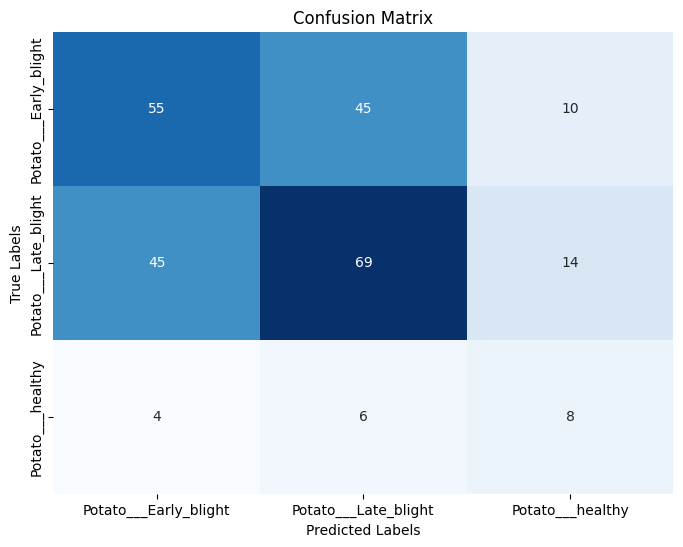

In [153]:
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns

confusion_matrix = sklearn.metrics.confusion_matrix(true_labels, predicted_labels)

print(confusion_matrix)
class_names = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)

# Set tick labels
tick_labels = [class_names[i] for i in range(len(class_names))]
plt.xticks(ticks=[0.5, 1.5, 2.5], labels=tick_labels, ha='center')
plt.yticks(ticks=[0.5, 1.5, 2.5], labels=tick_labels, va='center')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# cm = confusion_matrix(true_labels, predicted_labels)
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.title("Confusion Matrix")
# plt.xticks(ticks=np.arange(len(3)), labels=class_names)
# plt.yticks(ticks=np.arange(len(3)), labels=class_names)
# plt.show()

In [150]:
import sklearn.metrics

f1_score = sklearn.metrics.f1_score(true_labels, predicted_labels, average='macro')

print("F1 Score:", f1_score)


F1 Score: 0.463490101497337


**Now run inference on few sample images**

1/1 [==============================] - 0s 23ms/step


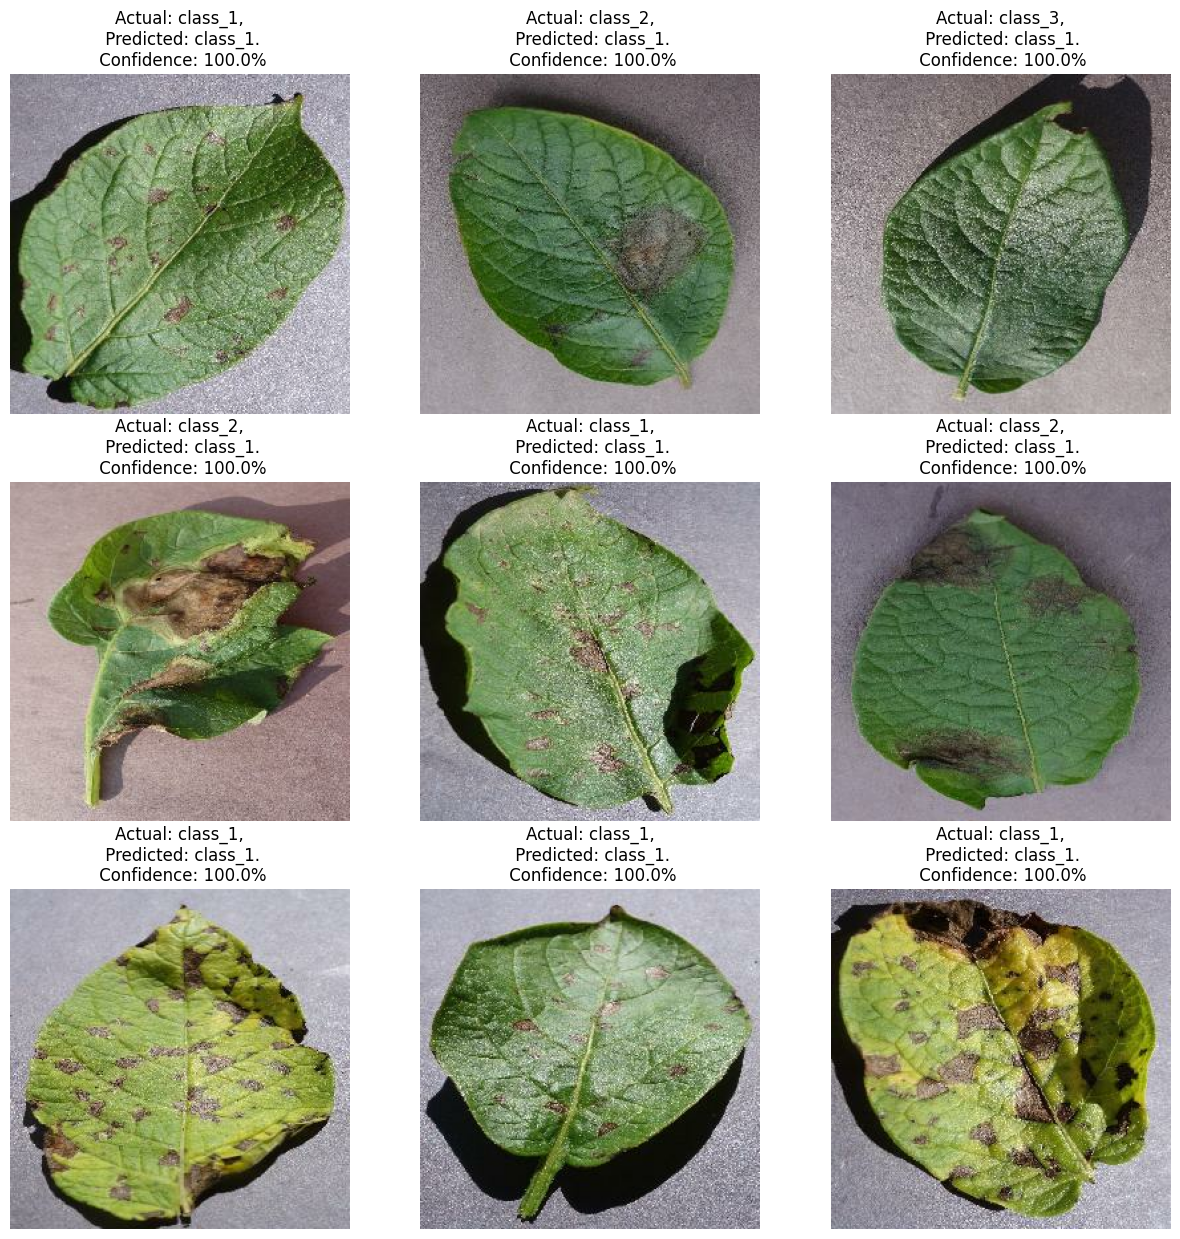

In [132]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, predicted_label, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

In [ ]:
model.save("../potatoes.h5")